In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import load
import torch

In [3]:
data_path = "../../data/mnist/"
x_test = torch.Tensor(load(f'{data_path}/x_test.npy').reshape((-1, 784)))
x_train = torch.Tensor(load(f'{data_path}/x_train.npy').reshape((-1, 784)))
y_test = torch.Tensor(load(f'{data_path}/y_test.npy'))
y_train = torch.Tensor(load(f'{data_path}/y_train.npy'))

In [4]:
x_train = x_train[:5000]
x_test = x_test[:500]
y_train = y_train[:5000]
y_test = y_test[:500]
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([5000, 784]) torch.Size([500, 784]) torch.Size([5000, 10]) torch.Size([500, 10])


In [5]:
print(x_train.shape)
print(y_train.shape)

print(torch.min(x_test))
print(torch.max(x_test))
print(y_train[0])


torch.Size([5000, 784])
torch.Size([5000, 10])
tensor(0.)
tensor(1.)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


In [6]:
def plot_image(x):
    plt.imshow(x, cmap='gray')
    # plt.show()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


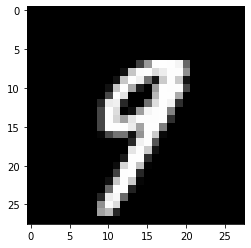

In [7]:
    
index = 12
plot_image(x_test[index].numpy().reshape((28, 28)))
print(y_test[index])
plt.show()

In [8]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

# Model

```yaml
Generator:
  - Input: 100 (90 noise, 10 one-hot)
  - h1: 150
  - h2: 400
  - h3: 784

FeatureExtractor:
  - Input: 784 (28x28)
  - h1: 400
  - h2: 150
  - h3: 100

Discriminator:
  - Input: 100
  - h1: 50
  - h2: 1

Classifier:
  - Input: 100
  - h1: 50
  - h2: 10
```

In [9]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 6000)), torch.zeros(6000, requires_grad=True)
        self.w2, self.b2 = get_random((6000, 2000)), torch.zeros(2000, requires_grad=True)
        self.w3, self.b3 = get_random((2000, 784)), torch.zeros(784, requires_grad=True)
    
    def forward(self, x, **kwargs):
        # x.shape = (batch, 100)
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()
        
    def zero_grad(self):
        self.w1.grad = torch.zeros(self.w1.grad.shape)
        self.w2.grad = torch.zeros(self.w2.grad.shape)
        self.w3.grad = torch.zeros(self.w3.grad.shape)
        
        self.b1.grad = torch.zeros(self.b1.grad.shape)
        self.b2.grad = torch.zeros(self.b2.grad.shape)
        self.b3.grad = torch.zeros(self.b3.grad.shape)

In [10]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 600)), torch.zeros(600, requires_grad=True)
        self.w2, self.b2 = get_random((600, 600)), torch.zeros(600, requires_grad=True)
        self.w3, self.b3 = get_random((600, 100)), torch.zeros(100, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()
        

In [11]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 50)), torch.zeros(50, requires_grad=True)
        self.w2, self.b2 = get_random((50, 1)), torch.zeros(1, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        return h2
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()

In [12]:
    
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 50)), torch.zeros(50, requires_grad=True)
        self.w2, self.b2 = get_random((50, 10)), torch.zeros(10, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.nn.functional.softmax(h1.matmul(self.w2) + self.b2)
        return h2
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()


In [13]:
fe = FeatureExtractor()
classifier = Classifier()
discriminator = Discriminator()
generator = Generator()


In [20]:
batch_size = 200
epochs = 5

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = [0, 0, 0, 0]
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
    
        
        # ------------ Train with real image ----------------
        real = torch.ones(batch_size)
        fake = torch.zeros(batch_size)
        
        features = fe(x_batch)
        discriminator_out = discriminator(features)
        #  classifier_out = classifier(features)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        #  loss_classifier = torch.nn.functional.binary_cross_entropy(classifier_out, y_batch)
        
        loss = loss_discriminator #  + loss_classifier
        loss.backward()
        discriminator.optimize(0.1)
        #  classifier.optimize(0.1)
        fe.optimize(0.1)
        
        losses[0] += float(loss)
        
        # --------------- Train with fake image -------------------
        
        generator_input = np.random.uniform(0, 1, (batch_size, 90))
        generator_input = np.concatenate((generator_input, y_batch), axis=1)
        generator_input = torch.Tensor(generator_input)
        
        generated = generator(generator_input)
        features = fe(generated)
        discriminator_out = discriminator(features)
        #  classifier_out = classifier(features)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, fake)
        loss_generator = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        #  loss_classifier = torch.nn.functional.binary_cross_entropy(classifier_out, y_batch)
        loss = loss_discriminator  # + loss_classifier
        
        loss.backward(retain_graph=True)
        
        discriminator.optimize(0.1)
        fe.optimize(0.1)
        
        generator.zero_grad()
        loss_generator.backward()
        generator.optimize(0.1)
        
        losses[1] += float(loss_discriminator)
        # losses[2] += float(loss_classifier)
        losses[3] += float(loss_generator)
        
    print(f'  Losses: {losses}')


Epoch: 0
  Losses: [0.027056685532443225, 0.032729963306337595, 0, 166.0261492729187]
Epoch: 1
  Losses: [0.025186324026435614, 0.027855338877998292, 0, 170.07479047775269]
Epoch: 2
  Losses: [0.02275139157427475, 0.02798267430625856, 0, 169.96450567245483]
Epoch: 3
  Losses: [0.022629409795626998, 0.03148824512027204, 0, 167.04740381240845]
Epoch: 4
  Losses: [0.021853330312296748, 0.02842555963434279, 0, 169.52638292312622]


d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.


d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


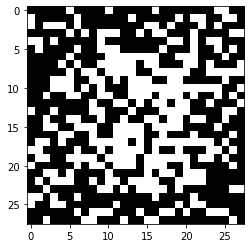

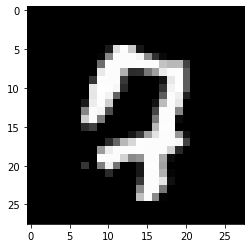

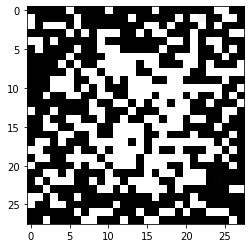

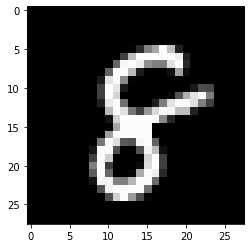

Discriminator_out fake: tensor([[0.0012],
        [0.0012]])
Real Img Discriminator Out: tensor([[0.9999],
        [0.9997]])

Class: tensor([[0.0979, 0.0109, 0.0348, 0.0539, 0.1633, 0.0867, 0.0231, 0.2047, 0.0657,
         0.2590],
        [0.1000, 0.0074, 0.0089, 0.0634, 0.0477, 0.1757, 0.0348, 0.0334, 0.4026,
         0.1262]])
Real class: tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


In [19]:
with torch.no_grad():
    
    index = 133
    batch_size = 2
    
    x_sample = x_test[index:index+batch_size]
    y_sample = y_test[index:index+batch_size]
    
    generator_input = np.random.uniform(0, 1, (batch_size, 90))
    generator_input = np.concatenate((generator_input, y_sample), axis=1)
    generator_input = torch.Tensor(generator_input)
        
    generated = generator(generator_input)
    features = fe(generated)
    discriminator_out = discriminator(features)
    
    features = fe(x_sample)
    real_discriminator_out = discriminator(features)
    classifier_out = classifier(features)

    
    for i in range(batch_size):
        plot_image(generated[i].reshape((28, 28)))
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)))
        plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {classifier_out}\nReal class: {y_sample}")
    

In [ ]:
# This is just the classifier.

batch_size = 20
lr = 0.5
epochs = 10

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        
        features = fe(x_batch)
        classes = classifier(features)
        
        loss = torch.nn.functional.binary_cross_entropy(classes, y_batch)
        loss.backward()
        
        fe.optimize(lr)
        classifier.optimize(lr)
        
        losses += loss.detach().numpy()
    print(f' Loss: {losses}')

In [ ]:
with torch.no_grad():
    index = 133
    x_sample = x_test[index:index+2]
    y_sample = y_test[index:index+2]
    y_pred = classifier(fe(x_sample))
    print(y_pred)
    print(y_sample)